In [1]:
import os
import cv2
import glob
import torch
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import math
from collections import defaultdict
from matplotlib import pyplot as plt
import umap
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
class SingleChannelImageDataset(Dataset):
    def __init__(self, folder_path, image_size=224, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.masks = {}

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = non-recurrent, 1 = recurrent)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        slide_num = self.image_files[idx].split("/")[-2].split("_")[0][:6]
        tissue_num = self.image_files[idx].split("/")[-2].split("_")[0][6:]
        mask_name = slide_num + "_" + tissue_num
        image = Image.open(self.image_files[idx]).convert('L') 
        mask = Image.fromarray(self.masks[mask_name])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, label, mask  # Return both image, label and mask

In [3]:
# define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/cropped_v2/'
dataset = SingleChannelImageDataset(folder_path, image_size=224, transform=None)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
def plot_sampled_patches(image, coordinates, patch_size, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of sampled patches.
        patch_size (int): Size of the square patch.
    """
    image_copy = image.copy()
    image_array = np.array(image_copy)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    for (x_start, y_start) in coordinates:
        top_left = (y_start, x_start)
        bottom_right = (y_start + patch_size, x_start + patch_size)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)

    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    return ax

In [5]:
import numpy as np
from PIL import Image

def construct_patches(img, patch_size=32):  # Now takes a PIL Image object
    """
    Cuts a PIL Image object into patches and converts each patch to a NumPy array.

    Args:
        img: A PIL Image object.
        patch_size: Size of each square patch (default: 32 for 224x224 image).

    Returns:
        A list of NumPy arrays, where each array represents a patch.
        Returns None if there's an error processing the image.
    """
    img_array = np.array(img)  # Convert PIL Image to NumPy array
    patches = []
    for i in range(0, img_array.shape[0], patch_size):  # Iterate over rows
        for j in range(0, img_array.shape[0], patch_size):  # Iterate over columns
            patch = img_array[i:i + patch_size, j:j + patch_size,:]  # Extract patch
            patches.append(patch)

    return patches
    

In [6]:
def quilting_image(patches_a, patches_b, patch_size, percentage_a=0.5):
    """
    Reconstructs an image by randomly picking patches from two lists,
    with a specified percentage of patches coming from list A.

    Args:
        patches_a: A list of NumPy arrays (patches from image A).
        patches_b: A list of NumPy arrays (patches from image B).
        percentage_a: The percentage of patches to be selected from patches_a (default: 0.5).

    Returns:
        A PIL Image object representing the reconstructed image, or None if there's an error.
    """
    
    
    
    if len(patches_a) != len(patches_b):  # patch counts must match
        raise ValueError("Length of both lists must match!")
    
    num_rows = int(math.sqrt(len(patches_a)))  # number of patches per row is square root of length of patch list
    
    try:
        quilted_image = np.zeros((num_rows * patch_size, num_rows * patch_size), dtype=np.uint8)
        patch_index = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # choose between A and B based on percentage_a
                if random.random() < percentage_a:  # random.random() returns a float between 0 and 1
                    chosen_patch = patches_a[patch_index]
                else:
                    chosen_patch = patches_b[patch_index]

                row_start = i * patch_size
                row_end = row_start + patch_size
                col_start = j * patch_size
                col_end = col_start + patch_size
                quilted_image[row_start:row_end, col_start:col_end] = chosen_patch
                patch_index += 1
        
        return Image.fromarray(quilted_image)

    except Exception as e:
        print(f"Error reconstructing image: {e}")
        return None

In [7]:
def sample_coordinates_from_roi(binary_image, max_patches, patch_size, overlap):
    """
    Randomly sample n coordinates from white regions (value 255) in a binary image.
    
    Args:
        binary_image: PIL Image or numpy array with binary values (0, 255)
        max_patches: maximum number of patches
        patch_size: the size of the patch
        overlap: acceptable overlap between patches
        
    Returns:
        numpy.ndarray: Array of shape (max_patches, 2) containing (x, y) coordinates
    """
    # convert PIL Image to numpy array if needed
    if isinstance(binary_image, Image.Image):
        img_array = np.array(binary_image)
    else:
        img_array = binary_image
        
    min_distance = patch_size - patch_size * overlap # calculate the minimum distance between each future sampled coordinate
    
    # find coordinates of white pixels in the mask image (value 255)
    white_pixels = np.where(img_array == 255)
    all_coords = np.column_stack((white_pixels[0], white_pixels[1]))
    
    # create a set of tuples for faster membership testing
    # note that we use (y,x) format for coordinates since that's how NumPy indexes images
    coords_set = set(map(tuple, all_coords))
    
    # find valid candidate points that have the bottom right coordinate also in white region
    valid_candidates = []
    valid_indices = []
    
    for idx, (y, x) in enumerate(all_coords):
        bottom_right_coord = (y + patch_size, x + patch_size)  # Note: offset is (x,y) but coords are (y,x)
        if bottom_right_coord in coords_set:
            valid_candidates.append((y, x))
            valid_indices.append(idx)
    
    valid_candidates = np.array(valid_candidates)
    
    # check if we have enough white pixels
    if len(valid_candidates) < max_patches:
        raise ValueError(f"Not enough valid candidates ({len(valid_candidates)}) to sample {max_patches} coordinates")
    
    # create a mask that will be updated to 0 in regions where points are already placed
    # we'll start with all 1s where valid points exist
    point_mask = np.zeros_like(img_array, dtype=bool)
    for y, x in valid_candidates:
        point_mask[y, x] = True
        
    # array to store sampled coordinates
    sampled_coords = []
    
    for _ in range(max_patches):
        # if we've eliminated all possible points, break
        if not np.any(point_mask):
            break
            
        # get indices where mask is True (valid points remain)
        remaining_y, remaining_x = np.where(point_mask)
        remaining_indices = np.arange(len(remaining_y))
        
        # shuffle to randomly sample
        np.random.shuffle(remaining_indices)
        
        # try points in random order
        found_point = False
        for idx in remaining_indices:
            y, x = remaining_y[idx], remaining_x[idx]
            
            # if this point and its offset are both valid
            if (y, x) in coords_set and (y + patch_size, x + patch_size) in coords_set:
                sampled_coords.append((y, x))
                found_point = True
                
                # create a circular mask to remove points that are too close
                y_indices, x_indices = np.ogrid[-y:img_array.shape[0]-y, -x:img_array.shape[1]-x]
                dist_mask = y_indices*y_indices + x_indices*x_indices <= min_distance*min_distance
                point_mask[dist_mask] = False
                
                break
        # we couldn't find another valid point        
        if not found_point:
            break
    
    # check if we got enough samples
    if len(sampled_coords) < max_patches:
        print(f"Warning: Could only find {len(sampled_coords)} points with minimum distance {min_distance} between patches.")
    return sampled_coords

<Axes: >

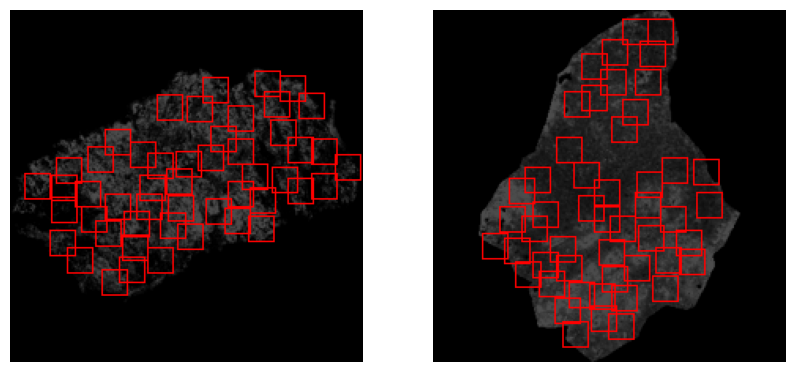

In [8]:
# Display some example images and their sampled coordinates
img1, label1, mask1 = dataset[0] # example 1
img2, label2, mask2 = dataset[27] # example 2
coords1 = sample_coordinates_from_roi(mask1, 50, 16, 0.3)
coords2 = sample_coordinates_from_roi(mask2, 50, 16, 0.3)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plot_sampled_patches(img1, coords1, 16, ax=axes[0])
plot_sampled_patches(img2, coords2, 16, ax=axes[1])

In [9]:
def extract_patches(image, coordinates, patch_size):
    """
    Extract patches from an image using the given coordinates.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of patches.
        patch_size (int): Size of the square patch.

    Returns:
        List[np.ndarray]: A list of extracted patches as NumPy arrays.
    """
    patches = [
        image[x_start:x_start + patch_size, y_start:y_start + patch_size]
        for x_start, y_start in coordinates
    ]
    return patches

def create_patches_by_label(dataset, max_patches=50, patch_size=16, overlap=0.5):
    """
    Construct a quited image dataset synthesized existing Dataset object

    Args:
        dataset: a Dataset object that contains the images
        max_patches: maximum number of patches that can be drawn on the image
        patch_size: the size of the patches
        overlap: how much two patches can overlap each other

    Returns:
        A directory containing generated quilted images
    """
    patches_by_label = defaultdict(list)
    for img, label, mask in dataset:
        coords = sample_coordinates_from_roi(mask, max_patches, patch_size, overlap) # sample maximum 32 patches of size 8x8
        patches = extract_patches(np.array(img), coords, patch_size)
        patches_by_label[label].extend(patches)
    return patches_by_label

patches_by_label = create_patches_by_label(dataset, 100, 16, 0.2)

In [10]:
draw_size = 196 # there are 784 of 8x8 patches in a 224x224 picture
num_draws = 500  # draw pictures for example   

# randomly drawing 196 samples 3 times from the patches_by_label 
example_patches_0 = [random.sample(patches_by_label[0], draw_size) for _ in range (num_draws)]
example_patches_1 = [random.sample(patches_by_label[1], draw_size) for _ in range(num_draws)]

# shuffle the list of patches
random.shuffle(example_patches_0)
random.shuffle(example_patches_1)

In [11]:
positive_quilts = []
negative_quilts = []
for i in range(100):
    positive_quilted_np = np.array(quilting_image(random.choice(example_patches_0), random.choice(example_patches_0), 16, 0.5))
    negative_quilted_np = np.array(quilting_image(random.choice(example_patches_0), random.choice(example_patches_1), 16, 0.5))
    positive_quilts.append(positive_quilted_np)
    negative_quilts.append(negative_quilted_np)

In [12]:
class CustomQuiltedDataset(Dataset):
    def __init__(self, positive_quilts, negative_quilts, transform=None):
        self.images = positive_quilts
        self.images.extend(negative_quilts)
        self.labels = [1] * len(positive_quilts)
        self.labels.extend([0] * len(negative_quilts))
        self.transform = transform
                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

quilted_dataset = CustomQuiltedDataset(positive_quilts, negative_quilts, transform=transform)
quilted_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
# Get a batch of 25 images for visualization
dataiter = iter(quilted_dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 25
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [ ]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 20
epochs = 10
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cpu")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in quilted_dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, quilted_dataloader, latent_dim=20, use_tsne=False)


In [ ]:
visualize_latent_space(model, quilted_dataloader, latent_dim=20, use_tsne=True)